<h1 align="center">Web Scraping 2</h1>
    <Name>
    <Class>
    <Date>

In [2]:
import re
import time
import requests
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

from matplotlib import pyplot as plt, rcParams
%matplotlib inline
# rcParams["figure.figsize"] = (16,12)    # Use this line to increase your figure size 

`wunder_temp()` gathers the Actual Mean Temperature, Actual Max Temperature, and Actual Min Temperature for every day in July of 2012.
Plotted these three measurements against time on the same plot.

In [7]:
# Problem 1
def wunder_temp(day="/history/airport/KSAN/2012/7/1/DailyHistory.html"):
    """Crawl through Weather Underground and extract temperature data."""
    # Initialize variables, including a regex for finding the 'Next Day' link.
    actual_mean_temp = []
    actual_max_temp = []
    actual_min_temp = []
    next_day_finder = re.compile(r"Next Day")
    base_url = "https://www.wunderground.com"       # Web page base URL.
    page = base_url + day                           # Complete page URL.
    current_mean = None
    current_max = None
    current_min = None
    

    for _ in range(31):
        while current_mean is None:  # Try downloading until it works.
            # Download the page source and PAUSE before continuing.
            page_source = requests.get(page).text
            time.sleep(1)           # PAUSE before continuing.
            soup = BeautifulSoup(page_source, "html.parser")
            current_mean = soup.find(string="Mean Temperature")
            current_max = soup.find(string="Max Temperature")
            current_min = soup.find(string="Min Temperature")

        # Navigate to the relevant tag, then extract the temperature data.
        temp_tag_mean = current_mean.parent.parent.next_sibling.next_sibling.span.span
        actual_mean_temp.append(int(temp_tag_mean.string))
        
        temp_tag_max = current_max.parent.parent.next_sibling.next_sibling.span.span
        actual_max_temp.append(int(temp_tag_max.string))

        temp_tag_min = current_min.parent.parent.next_sibling.next_sibling.span.span
        actual_min_temp.append(int(temp_tag_min.string))

        # Find the URL for the page with the next day's data.
        new_day = soup.find(string=next_day_finder).parent["href"]
        page = base_url + new_day                   # New complete page URL.
        current_mean = None
        current_max = None
        current_min = None

    return actual_mean_temp, actual_max_temp, actual_min_temp

Get Data:

In [8]:
actual_mean_temp, actual_max_temp, actual_min_temp = wunder_temp()

Plot data:

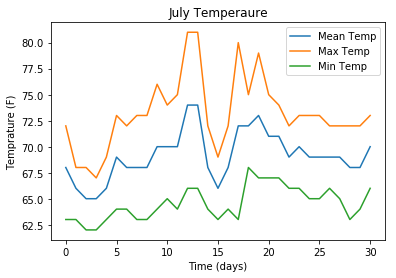

In [12]:
plt.plot(np.arange(31),actual_mean_temp, label='Mean Temp')
plt.plot(np.arange(31),actual_max_temp, label='Max Temp')
plt.plot(np.arange(31),actual_min_temp, label='Min Temp')
plt.xlabel("Time (days)")
plt.ylabel("Temprature (F)")
plt.title("July Temperaure")
plt.legend(loc='best')

`bank_data()` extracts the total consolidated assets ("Consol Assets") for JPMorgan Chase, Bank of America, and Wells Fargo recorded each December from 2004 to the present.
Plotted each bank’s assets against time.

In [28]:
# Problem 2
def bank_data2():
    """Crawl through the Federal Reserve site and extract bank data."""
    # Compile regular expressions for finding certain tags.
    link_finder = re.compile(r"December 31, 20((0[4-9])|(1[0-9]))$")
    chase_bank_finder = re.compile(r"^JPMORGAN CHASE BK")
    america_bank_finder = re.compile(r"^BANK OF AMER")
    wells_bank_finder = re.compile(r"^WELLS FARGO")

    # Get the base page and find the URLs to all other relevant pages.
    base_url="https://www.federalreserve.gov/releases/lbr/"
    base_page_source = requests.get(base_url).text
    base_soup = BeautifulSoup(base_page_source, "html.parser")
    link_tags = base_soup.find_all(name='a', href=True, string=link_finder)
    pages = [base_url + tag.attrs["href"] for tag in link_tags]

    # Crawl through the individual pages and record the data.
    chase_assets = []
    america_assets = []
    wells_assets = []
    for page in pages:
        time.sleep(1)               # PAUSE, then request the page.
        soup = BeautifulSoup(requests.get(page).text, "html.parser")

        # Find the tag corresponding to Chase Banks's consolidated assets.
        temp_tag1 = soup.find(name="td", string=chase_bank_finder)
        temp_tag2 = soup.find(name="td", string=america_bank_finder)
        temp_tag3 = soup.find(name="td", string=wells_bank_finder)
        for _ in range(10):
            temp_tag1 = temp_tag1.next_sibling
            temp_tag2 = temp_tag2.next_sibling
            temp_tag3 = temp_tag3.next_sibling
        # Extract the data, removing commas.
        chase_assets.append(int(temp_tag1.string.replace(',', '')))
        america_assets.append(int(temp_tag2.string.replace(',', '')))
        wells_assets.append(int(temp_tag3.string.replace(',', '')))

    return chase_assets, america_assets, wells_assets

In [29]:
chase_assets, america_assets, wells_assets = bank_data2()

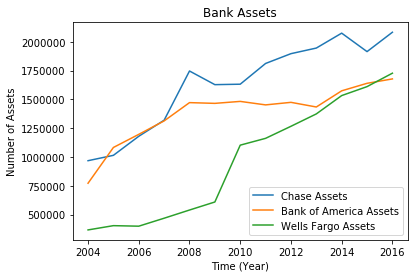

In [32]:
plt.plot(np.arange(2004,2017),chase_assets[::-1], label='Chase Assets')
plt.plot(np.arange(2004,2017),america_assets[::-1], label='Bank of America Assets')
plt.plot(np.arange(2004,2017),wells_assets[::-1], label='Wells Fargo Assets')
plt.xlabel("Time (Year)")
plt.ylabel("Number of Assets")
plt.title("Bank Assets")
plt.legend(loc='best')

ESPN hosts data on NBA athletes at http://www.espn.go.com/nba/statistics.
Each player has their own page with detailed performance statistics.
For each of the five offensive leaders in points and each of the five defensive leaders in rebounds, extracted the player's career minutes per game (MPG) and career points per game (PPG).
Made a scatter plot of MPG against PPG for these ten players.

In [95]:
# Problem 3
def nba_stats():
    MPG = []
    PPG = []
    base_url="http://www.espn.go.com/nba/statistics"
    base_page_source = requests.get(base_url).text
    base_soup = BeautifulSoup(base_page_source, "html5lib")
    
    offense = base_soup.find(string="Offensive Leaders").parent.parent.next_sibling
    defense = base_soup.find(string="Defensive Leaders").parent.parent.next_sibling
    
    link_tags_off = offense.find_all(name='a', href=True)
    pages_off = [tag.attrs["href"] for tag in link_tags_off][2:-1]
    
    link_tags_def = defense.find_all(name='a', href=True)
    pages_def = [tag.attrs["href"] for tag in link_tags_def][2:-1]
    
    for page in pages_off:
        time.sleep(1)               # PAUSE, then request the page.
        soup_off = BeautifulSoup(requests.get(page).text, "html5lib")
        temp_tag = soup_off.find(string="2016-17 Regular Season").parent.parent.parent
        temp_tag = temp_tag.find(string="Career").parent
        
        for _ in range(15):
            temp_tag = temp_tag.next_sibling
            if _ == 1:
                MPG.append(float(temp_tag.string))
            if _ == 14:
                PPG.append(float(temp_tag.string))
        
    for page in pages_def:
        time.sleep(1)               # PAUSE, then request the page.
        soup_def = BeautifulSoup(requests.get(page).text, "html5lib")
        temp_tag = soup_def.find(string="2016-17 Regular Season").parent.parent.parent
        temp_tag = temp_tag.find(string="Career").parent
        
        for _ in range(15):
            temp_tag = temp_tag.next_sibling
            if _ == 1:
                MPG.append(float(temp_tag.string))
            if _ == 14:
                PPG.append(float(temp_tag.string))
    return MPG, PPG

In [98]:
MPG, PPG = nba_stats()

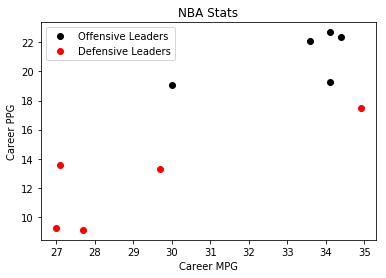

In [105]:
plt.plot(MPG[0:5],PPG[0:5],"ok", label='Offensive Leaders')
plt.plot(MPG[5:],PPG[5:],"or", label='Defensive Leaders')
plt.title('NBA Stats')
plt.xlabel('Career MPG')
plt.ylabel('Career PPG')
plt.legend(loc='best')
plt.show()

The arXiv is an online repository of scientific publications, hosted by Cornell University.
`search(search_query)` accepts a string to serve as a search query.
Used Selenium to enter the query into the search bar of https://arxiv.org and press Enter.
The resulting page has up to 25 links to the PDFs of technical papers that match the query.
Gathered these URLs, then continued to the next page (if there are more results) and continued gathering links until obtaining at most 100 URLs.

Printed the list of URLs below.

In [154]:
# Problem 4
def search(search_query):
    all_urls = []
    base_url = "https://arxiv.org"
    link_finder = re.compile(r"^Next .")
    browser = webdriver.Chrome()
    try:
        browser.get(base_url)
        try:
            # Get the search bar, type in some text, and press Enter.
            search_bar = browser.find_element_by_name('query')
            search_bar.clear()                  # Clear any pre-set text.
            search_bar.send_keys(search_query)
            search_bar.send_keys(Keys.RETURN)   # Press Enter.
            i = 0
            t = True
            while i < 4 and t == True:
                time.sleep(1)
                soup = BeautifulSoup(browser.page_source, "html.parser")
                geturls = soup.find_all(title="Download PDF")
                geturls = [base_url + tag.attrs["href"] for tag in geturls]
                all_urls += geturls
                if len(geturls) == 25:
                    next_page = soup.find(string =link_finder).parent.attrs["href"]
                    browser.get(base_url + next_page)
                else:
                    t = False
                i += 1
        except NoSuchElementException:
            print("Could not find the search bar!")
            raise
    finally:
        browser.close()
        
    return all_urls

In [157]:
search_query = "particle"
results = search(search_query)
print(*results)

https://arxiv.org/pdf/adap-org/9911006 https://arxiv.org/pdf/adap-org/9911005 https://arxiv.org/pdf/adap-org/9906004 https://arxiv.org/pdf/astro-ph/9902079 https://arxiv.org/pdf/astro-ph/9902076 https://arxiv.org/pdf/astro-ph/9902072 https://arxiv.org/pdf/astro-ph/9902042 https://arxiv.org/pdf/astro-ph/9902041 https://arxiv.org/pdf/astro-ph/9902040 https://arxiv.org/pdf/astro-ph/9902036 https://arxiv.org/pdf/astro-ph/9901417 https://arxiv.org/pdf/astro-ph/9901400 https://arxiv.org/pdf/astro-ph/9901390 https://arxiv.org/pdf/astro-ph/9901384 https://arxiv.org/pdf/astro-ph/9901375 https://arxiv.org/pdf/astro-ph/9901367 https://arxiv.org/pdf/astro-ph/9901358 https://arxiv.org/pdf/astro-ph/9901340 https://arxiv.org/pdf/astro-ph/9901324 https://arxiv.org/pdf/astro-ph/9901305 https://arxiv.org/pdf/astro-ph/9901257 https://arxiv.org/pdf/astro-ph/9901231 https://arxiv.org/pdf/astro-ph/9901223 https://arxiv.org/pdf/astro-ph/9901222 https://arxiv.org/pdf/astro-ph/9901219 https://arxiv.org/pdf/ast

Project Euler (https://projecteuler.net) is a collection of mathematical computing problems.
Each problem is listed with an ID, a description/title, and the number of users that have solved the problem.

`projectEuler()` uses Selenium and BeautifulSoup for each of the (at least) 600 problems in the archive at https://projecteuler.net/archives, records the problem ID and the number of people who have solved it.
Returns a list of IDs, sorted from largest to smallest by the number of people who have solved them.
That is, the first entry in the list should be the ID of the most solved problem, and the last entry in the list should be the ID of the least solved problem.

In [46]:
# Problem 5
def projectEuler():
    all_IDs = []
    base_url = "https://projecteuler.net/archives"
    browser = webdriver.Chrome()
    pages = [";page=1",";page=2",";page=3",";page=4",";page=5",
             ";page=6",";page=7",";page=8",";page=9",";page=10",
             ";page=11",";page=12",";page=13"]
    urls = [base_url + page for page in pages]
    try:
        for url in urls:
            time.sleep(1)
            browser.get(url)
            soup = BeautifulSoup(browser.page_source, "html.parser")
            ID_tags = soup.find_all(class_="id_column")
            IDs = [ID.string for ID in ID_tags][1:]
            all_IDs += IDs
        solved = [int(ID.parent.parent.find(name='div').string) for ID in all_IDs]
        index = np.argsort(solved)
        all_IDs = np.array(all_IDs)[index][::-1]
    finally:
        browser.close()
        
    return all_IDs

In [47]:
problem_IDs = projectEuler()
print(problem_IDs)

['1' '2' '3' '6' '5' '4' '7' '9' '8' '10' '11' '16' '13' '14' '12' '20'
 '15' '25' '17' '18' '21' '19' '22' '48' '24' '28' '30' '29' '23' '67' '34'
 '36' '27' '35' '31' '26' '40' '42' '37' '39' '33' '45' '32' '41' '52' '38'
 '50' '46' '53' '43' '56' '47' '49' '44' '55' '97' '79' '63' '92' '59' '57'
 '58' '54' '81' '69' '51' '99' '62' '65' '71' '76' '74' '60' '73' '61' '85'
 '112' '206' '70' '72' '89' '102' '64' '82' '87' '68' '80' '66' '77' '83'
 '75' '96' '145' '78' '104' '100' '91' '205' '124' '120' '95' '125' '108'
 '86' '84' '119' '116' '94' '123' '179' '187' '93' '113' '117' '98' '107'
 '101' '90' '114' '115' '121' '243' '88' '173' '203' '110' '109' '105'
 '103' '122' '204' '131' '191' '111' '357' '134' '118' '188' '132' '135'
 '106' '129' '144' '127' '174' '301' '130' '142' '164' '138' '231' '136'
 '139' '162' '133' '151' '214' '137' '235' '197' '148' '169' '146' '345'
 '207' '128' '183' '149' '225' '126' '265' '190' '211' '140' '216' '166'
 '493' '150' '347' '172' '215' '381' '3